In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [48]:
import scipy.sparse as sps
import matplotlib.pyplot as pyplot

In [72]:
list_of_files = []
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        list_of_files.append(os.path.join(dirname, filename))

for file in list_of_files:
    if file.endswith("interactions_and_impressions.csv"):
        URM_dataframe = pd.read_csv(file)


C:\Users\baba7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
URM_dataframe.columns = ["UserID", "ItemID", "Impressions", "Data"]

In [51]:
print ("The number of interactions is {}".format(len(URM_dataframe)))
print ("The number of users is {}".format(len(URM_dataframe["UserID"].unique())))
print ("The number of items is {}".format(len(URM_dataframe["ItemID"].unique())))
print ("The number of items viewed is {}".format(len(URM_dataframe.loc[(URM_dataframe["Data"]==1)])))
print ("The number of details page openned is {}".format(len(URM_dataframe.loc[(URM_dataframe["Data"]==0)])))

The number of interactions is 5826506
The number of users is 41629
The number of items is 24507
The number of items viewed is 2259027
The number of details page openned is 3567479


In [52]:
mapped_id, original_id = pd.factorize(URM_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [53]:
URM_dataframe["UserID"] = URM_dataframe["UserID"].map(user_original_ID_to_index)
URM_dataframe["ItemID"] = URM_dataframe["ItemID"].map(item_original_ID_to_index)
URM_dataframe.dtypes

UserID          int64
ItemID          int64
Impressions    object
Data            int64
dtype: object

In [54]:
URM = sps.coo_matrix((URM_dataframe["Data"].values, 
                          (URM_dataframe["UserID"].values, URM_dataframe["ItemID"].values)))
URM

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 5826506 stored elements in COOrdinate format>

In [55]:
URM.tocsr()

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 1554640 stored elements in Compressed Sparse Row format>

## As a reminder :
*np.ediff1d()* The differences between consecutive elements of an array.

**Compressed Row Matrix :**

<img src="https://i.stack.imgur.com/12bPL.png" style="width:500px;">

In [56]:
URM.tocsc().indptr

array([      0,      65,    9546, ..., 1554601, 1554623, 1554640],
      dtype=int32)

We can compute the number of interactions for each items by compute the difference in the index pointer of the CSC ( => number of NNZ)

In [57]:
item_popularity = np.ediff1d(URM.tocsc().indptr)
item_popularity

array([  65, 9481, 6021, ...,   24,   22,   17], dtype=int32)

In [58]:
item_popularity = np.sort(item_popularity)
item_popularity

array([  12,   13,   13, ..., 5481, 6021, 9481], dtype=int32)

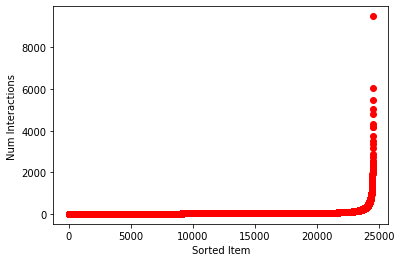

In [59]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [61]:
n_items = len(URM_dataframe["ItemID"].unique())
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 63.44
Average per-item interactions for the top 10% popular items 305.72
Average per-item interactions for the least 10% popular items 22.21
Average per-item interactions for the median 10% popular items 34.46


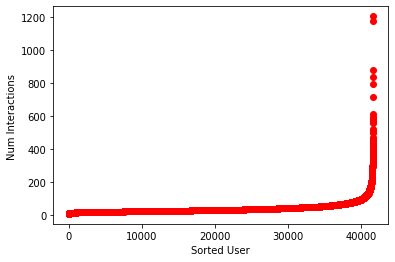

In [62]:
user_activity = np.ediff1d(URM.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A function computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [63]:
train_test_split = 0.80

n_interactions = URM.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ...,  True,  True, False])

In [64]:
URM_train = sps.csr_matrix((URM.data[train_mask],
                            (URM.row[train_mask], URM.col[train_mask])))

URM_train

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 1312033 stored elements in Compressed Sparse Row format>

In [65]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM.data[test_mask],
                            (URM.row[test_mask], URM.col[test_mask])))

URM_test

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 469420 stored elements in Compressed Sparse Row format>

### Evaluation metric
#### We call items in the test set 'relevant

In [66]:
user_id = 124
relevant_items = URM_test[user_id].indices
relevant_items

array([ 168,  550,  889, 1062, 1496, 3746, 3751, 3752])

#### Say that we have a recommendation list such as this

In [67]:
recommended_items = np.array([6060, 1622, 15, 857, 5823])
recommended_items

array([6060, 1622,   15,  857, 5823])

In [68]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [69]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

In [70]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

In [71]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score